# Heart Disease Classification - Part 2

In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Load and clean dataset

In [46]:
heart_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None)
heart_data.columns = ['Age', 'Sex', 'ChestPain', 'trestBPS', 'chol', 'fbs', 'restecg', 'thalach',
                     'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

def impute_missing(df):
    heart_data.replace('?', np.NaN, inplace=True)
    for col in df:
        df[col].fillna(df[col].mode()[0], inplace=True)

impute_missing(heart_data)


def change_data(df):
    for col in df:
        if col in ['Sex', 'ChestPain', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']:
            df[col] = df[col].astype('category')
            
change_data(heart_data)

heart_data['target'] = heart_data['target'].replace([2,3,4], 1)
heart_data['target'].cat.remove_categories([2,3,4], inplace=True)

# Model

In [47]:
X = heart_data.iloc[:, :-1]
y = heart_data['target']

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

### Dummy Classifier, Forest, Gradient Boosting

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier

In [50]:
dummy = DummyClassifier(strategy='most_frequent')
rf = RandomForestClassifier()
gb = GradientBoostingClassifier(n_estimators=100)

In [51]:
from sklearn.model_selection import cross_validate

def model_evaluate(models, style):
    '''
    For a given model, run cross_validate to get multiple evaluation metrics and return a dataframe with the models and metrics
    '''
    
    scores ={'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'f1':[], 'roc_auc':[]}

    for model in models:
        sco = cross_validate(model, X_train,y_train, cv=5, scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), return_train_score = True)
        scores['Model'].append(style + ' ' +type(model).__name__)
        scores['Accuracy'].append(sco['test_accuracy'].mean())
        scores['Precision'].append(sco['test_precision'].mean())
        scores['Recall'].append(sco['test_recall'].mean())
        scores['f1'].append(sco['test_f1'].mean())
        scores['roc_auc'].append(sco['test_roc_auc'].mean())
        model_eval = pd.DataFrame(scores)
    return model_eval

models=[dummy,rf,gb]
initial = model_evaluate(models, 'Initial')
initial

,Model,Accuracy,Precision,Recall,f1,roc_auc
0,Initial DummyClassifier,0.556603,0.000000,0.000000,0.000000,0.500000
1,Initial RandomForestClassifier,0.777903,0.808446,0.670175,0.725980,0.851634
2,Initial GradientBoostingClassifier,0.802172,0.802346,0.733918,0.764528,0.864130


## Hyperparameter tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

def search_model_evaluate(model, style):
    '''
    Given RandomSearchCV and GridSearchCV, find multiple scores and return a dataframe with those scores
    '''
    
    scores ={'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'f1':[], 'roc_auc':[]}

    model.fit(X_train, y_train)
    sco = model.cv_results_
    scores['Model'].append(style + ' ' +type(model).__name__)
    scores['Accuracy'].append(sco['mean_test_accuracy'].mean())
    scores['Precision'].append(sco['mean_test_precision'].mean())
    scores['Recall'].append(sco['mean_test_recall'].mean())
    scores['f1'].append(sco['mean_test_f1'].mean())
    scores['roc_auc'].append(sco['mean_test_roc_auc'].mean())
    search_model_eval = pd.DataFrame(scores)
    return search_model_eval

### Randomized Search for GradientBoosting

In [53]:
from scipy.stats import uniform

learning_rate = uniform(0.01,0.2)
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [3,5,10]#None]
min_samples_leaf = [1, 2, 4]

random_grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [54]:
gb = GradientBoostingClassifier()
gb_random = RandomizedSearchCV(gb, param_distributions = random_grid, n_iter=100, cv=5, scoring = scoring, refit='precision', return_train_score = True)

randomized_gb = search_model_evaluate(gb_random, 'GB')


,Model,Accuracy,Precision,Recall,f1,roc_auc
0,GB RandomizedSearchCV,0.784104,0.788645,0.710351,0.742683,0.865463


### GridSearch for GradientBoosting

In [55]:
def get_parameters_GB(model):
    randomsearch_params = model.get_params()
    grid_learning = randomsearch_params['learning_rate']
    grid_depth = randomsearch_params['max_depth']
    grid_estimators = randomsearch_params['n_estimators']
    grid_max_features = randomsearch_params['max_features']
    
    gridsearch_learning = [grid_learning, grid_learning+0.02, grid_learning+0.06]
    gridsearch_estimators = [grid_estimators-50, grid_estimators, grid_estimators+100]
    gridsearch_depth = [grid_depth -2, grid_depth, grid_depth+2]
    
    gridsearch_params={'learning_rate': gridsearch_learning,
                       'n_estimators': gridsearch_estimators,
                       'max_features': [grid_max_features],
                       'max_depth': gridsearch_depth}
    return gridsearch_params

gb_ran = GradientBoostingClassifier(**gb_random.best_params_) # gb_random is the model for randomsearchCV
gridsearch_params = get_parameters_GB(gb_ran)

In [56]:
#scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
gbclf = GradientBoostingClassifier()
gbclf_gridsearch = GridSearchCV(gbclf, gridsearch_params, cv=5, scoring=scoring, refit='precision', return_train_score = True)
gridsearch_gb = search_model_evaluate(gbclf_gridsearch,'GB')

In [57]:
pd.concat([initial, randomized_gb, gridsearch_gb])

,Model,Accuracy,Precision,Recall,f1,roc_auc
0,Initial DummyClassifier,0.556603,0.000000,0.000000,0.000000,0.500000
1,Initial RandomForestClassifier,0.777903,0.808446,0.670175,0.725980,0.851634
2,Initial GradientBoostingClassifier,0.802172,0.802346,0.733918,0.764528,0.864130
0,GB RandomizedSearchCV,0.784104,0.788645,0.710351,0.742683,0.865463
0,GB GridSearchCV,0.821454,0.843731,0.741218,0.784975,0.894409


### Randomized Search for Random Forest

In [58]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3,5,10]
#max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [59]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, param_distributions = rf_random_grid, n_iter=100, cv=5, scoring = scoring, refit='precision', return_train_score = True)
# Run the randomized search random forest model
randomized_rf = search_model_evaluate(rf_random, 'RF')
# Get the best parameters from the randomized model and create a random forest classifier
rf_ran = RandomForestClassifier(**rf_random.best_params_)


,Model,Accuracy,Precision,Recall,f1,roc_auc
0,RF RandomizedSearchCV,0.838208,0.867,0.757685,0.805771,0.904389


### GridSearchCV for Random Forest

In [60]:
def get_parameters_RF(model):
    randomsearch_params = model.get_params()
    grid_depth = randomsearch_params['max_depth']
    grid_estimators = randomsearch_params['n_estimators']
    grid_max_features = randomsearch_params['max_features']
    grid_min_samples_leaf = randomsearch_params['min_samples_leaf']
    grid_bootstrap = randomsearch_params['bootstrap']
    

    gridsearch_estimators = [grid_estimators-50, grid_estimators, grid_estimators+100]
    gridsearch_depth = [grid_depth -2, grid_depth, grid_depth+2]
    grid_min_samples_leaf = [grid_min_samples_leaf, grid_min_samples_leaf+2]
    
    
    gridsearch_params={'n_estimators': gridsearch_estimators,
                       'max_features': [grid_max_features],
                       'max_depth': gridsearch_depth,
                       'min_samples_leaf': grid_min_samples_leaf,
                       'bootstrap': [grid_bootstrap]}
    return gridsearch_params

# Get the best parameters from the randomized model and create a random forest classifier for GridSearch
rf_ran = RandomForestClassifier(**rf_random.best_params_)
rf_gridsearch_params = get_parameters_RF(rf_ran)

In [61]:
rfclf = RandomForestClassifier()
rfclf_gridsearch = GridSearchCV(rfclf, rf_gridsearch_params, cv=5, scoring=scoring, refit='precision', return_train_score = True)
gridsearch_rf = search_model_evaluate(rfclf_gridsearch,'RF')

In [62]:
pd.concat([initial, randomized_gb, gridsearch_gb, randomized_rf, gridsearch_rf])

,Model,Accuracy,Precision,Recall,f1,roc_auc
0,Initial DummyClassifier,0.556603,0.000000,0.000000,0.000000,0.500000
1,Initial RandomForestClassifier,0.777903,0.808446,0.670175,0.725980,0.851634
2,Initial GradientBoostingClassifier,0.802172,0.802346,0.733918,0.764528,0.864130
0,GB RandomizedSearchCV,0.784104,0.788645,0.710351,0.742683,0.865463
0,GB GridSearchCV,0.821454,0.843731,0.741218,0.784975,0.894409
0,RF RandomizedSearchCV,0.838208,0.867000,0.757685,0.805771,0.904389
0,RF GridSearchCV,0.841719,0.886873,0.743603,0.805585,0.908189


### Feature Selection

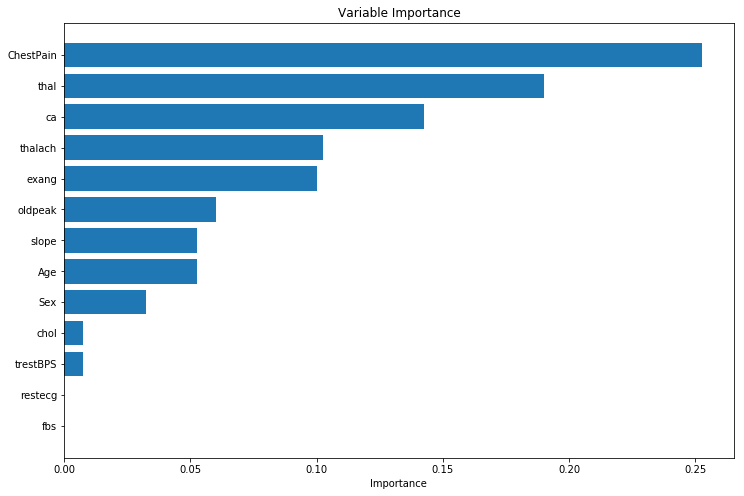

In [63]:
# Feature importance of gradient boost using the hypertuned parameters
rf_best = RandomForestClassifier(**rfclf_gridsearch.best_params_)
rf_best.fit(X_train, y_train)
feature_importance_rf = rf_best.feature_importances_
sorted_idx = np.argsort(feature_importance_rf)


pos= np.arange(sorted_idx.shape[0]) +0.5

plt.figure(figsize=(12,8))
plt.barh(pos,feature_importance_rf[sorted_idx], align='center')
plt.yticks(pos,X.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Variable Importance')
plt.show()

In [69]:
new_cols=X.columns[sorted_idx][7:].tolist()
new_X=X[new_cols]
new_X_train, new_X_test, y_train, y_test = train_test_split(new_X,y, test_size = 0.3)

rf_new = RandomForestClassifier(**rfclf_gridsearch.best_params_)
rf_new.fit(new_X_train, y_train)

sco = cross_validate(rf_new, new_X_train,y_train, cv=5, scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), return_train_score = True)

scores ={'Model':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'f1':[], 'roc_auc':[]}
sco['test_precision'].mean()
scores['Model'].append("New"+" " +type(rf_new).__name__)
scores['Accuracy'].append(sco['test_accuracy'].mean())
scores['Precision'].append(sco['test_precision'].mean())
scores['Recall'].append(sco['test_recall'].mean())
scores['f1'].append(sco['test_f1'].mean())
scores['roc_auc'].append(sco['test_roc_auc'].mean())
new_model_eval = pd.DataFrame(scores)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
pd.concat([initial.iloc[[1]], randomized_rf, gridsearch_rf, new_model_eval])

,Model,Accuracy,Precision,Recall,f1,roc_auc
1,Initial RandomForestClassifier,0.777903,0.808446,0.670175,0.725980,0.851634
0,RF RandomizedSearchCV,0.838208,0.867000,0.757685,0.805771,0.904389
0,RF GridSearchCV,0.841719,0.886873,0.743603,0.805585,0.908189
0,New RandomForestClassifier,0.859524,0.896032,0.760234,0.819376,0.911978
